# Introduction
As a prospective Airbnb host in Seattle, I have questions like:
* When to rent to maximise revenue, and for maintenance during off-peak?
* Common group size of Seattle travelers, is it 2 or family or 4 or larger?
* Bedroom configurations to maximise booking rates?
* Main factors to achieve good rating?
* Does higher ratings hosts has higher revenue?
* Common amenities to include?

In [0]:
#@title Load Packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print("Packages loaded")

Packages loaded


# Fetch and Prepare Data
Fetch listing and reviews data from csv files, and perform data cleaning
* review_score_xx that are empty are assumed that they do not have reviews, so set as zero
* bathrooms, bedrooms, and beds that are empty are assumed that they do not have, so set as zero
* price has dollar sign, remove it and cast as float
* covert date to pandas datatime type



In [0]:
#@title Load data from listings.csv
# get listings data
pd_listings = pd.read_csv("https://raw.githubusercontent.com/jinglescode/notebooks/master/kaggle/seattle_airbnb_open_data/listings.csv")

# select columns from pd_listings
pd_listings = pd_listings[['id','name','neighbourhood_group_cleansed','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','amenities','price','guests_included','minimum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

# basic data cleaning
pd_listings['price'] = pd_listings['price'].str.replace("[$, ]", "").astype("float")

pd_listings.at[pd_listings['bathrooms'].isnull(), 'bathrooms'] = 0
pd_listings.at[pd_listings['bedrooms'].isnull(), 'bedrooms'] = 0 # yea there are 6 that has no bedrooms, but they do have 1 bathrooms
pd_listings.at[pd_listings['beds'].isnull(), 'beds'] = 0 # there's one listing for 1 guest, without any beds

pd_listings.at[pd_listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
pd_listings.at[pd_listings['review_scores_accuracy'].isnull(), 'review_scores_accuracy'] = 0
pd_listings.at[pd_listings['review_scores_cleanliness'].isnull(), 'review_scores_cleanliness'] = 0
pd_listings.at[pd_listings['review_scores_checkin'].isnull(), 'review_scores_checkin'] = 0
pd_listings.at[pd_listings['review_scores_communication'].isnull(), 'review_scores_communication'] = 0
pd_listings.at[pd_listings['review_scores_location'].isnull(), 'review_scores_location'] = 0
pd_listings.at[pd_listings['review_scores_value'].isnull(), 'review_scores_value'] = 0

pd_listings.rename(columns={'id':'listing_id'}, inplace=True)

# pd_listings.describe()

print('listings.csv loaded into pd_listings')

listings.csv loaded into pd_listings


In [0]:
#@title Load data from reviews.csv
pd_reviews = pd.read_csv("https://raw.githubusercontent.com/jinglescode/notebooks/master/kaggle/seattle_airbnb_open_data/reviews.csv")

pd_reviews = pd_reviews[['id','listing_id','date']]

# basic conversions
pd_reviews['date'] = pd.to_datetime(pd_reviews['date'])

# pd_reviews.head()
print('reviews.csv loaded into pd_reviews')

reviews.csv loaded into pd_reviews


**Check if reviews.csv tally with listings.csv**

In listings.csv, it has 'number_of_reviews' column, so just to check if number of reviews in reviews.csv is equal to SUM(number_of_reviews). Result shows empty result (0 rows), means that the number of reviews in reviews.csv matches the sum of number_of_reviews in listings.csv. 

**Create bookings DataFrame**

With this, I shall create a dataframe pd_bookings using each review as one booking, and estimate revenue by (price * minimum_nights)

In [0]:
#@title 
pd_listing_count_reviws = pd_reviews[['listing_id','id']].groupby(['listing_id']).count()
pd_listing_count_reviws.columns = ['# of reviews']
# pd_listing_count_reviws['listing_id'] = pd_listing_count_reviws.index

pd_listings_plus_reviews = pd.merge(pd_listings, pd_listing_count_reviws, on='listing_id')

pd_listings_plus_reviews.at[pd_listings_plus_reviews['# of reviews'].isnull(), '# of reviews'] = 0

pd_listings_plus_reviews[ pd_listings_plus_reviews['# of reviews'] != pd_listings_plus_reviews['number_of_reviews']]

,listing_id,name,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,guests_included,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,# of reviews


In [0]:
#@title Calculate estimated revenue for each listing

# get estimated bookings base on reviews
pd_bookings = pd.merge(pd_reviews, pd_listings, on='listing_id')
pd_bookings['estimated_revenue'] = pd_bookings['price'] * pd_bookings['minimum_nights']

# get revenue by listings
pd_listings_revenue = pd_bookings[['listing_id','estimated_revenue']].groupby(['listing_id']).sum()
# pd_listings_revenue['listing_id'] = pd_listings_revenue.index

pd_listings = pd.merge(pd_listings, pd_listings_revenue, on='listing_id', how='left')
pd_listings.at[pd_listings['estimated_revenue'].isnull(), 'estimated_revenue'] = 0

# Time to answer some questions

In [0]:
#@title Showing 5 highest revenue listings
pd_listings[['listing_id','number_of_reviews','minimum_nights','accommodates','bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue', ascending=False).head()

,listing_id,number_of_reviews,minimum_nights,accommodates,bedrooms,beds,estimated_revenue
2617,3594885,8,1000,4,1.0,1.0,1200000.0
2107,5056580,100,31,2,1.0,1.0,306900.0
1500,4009508,38,20,5,2.0,2.0,266000.0
1537,1954452,71,14,2,1.0,1.0,218680.0
1519,3971934,48,20,3,1.0,1.0,171840.0


Wow! Looks like our top earners are hosts have minimum nights of 1000. But it might be data anomaly because 1000 nights are kind of extreme, so let's look at the proportion of listings with different minimum_nights.

In [0]:
pd_listings[['listing_id','minimum_nights']].groupby(['minimum_nights']).count().sort_values('minimum_nights')

,listing_id
minimum_nights,
1,1610
2,1423
3,480
4,122
5,67
6,16
7,50
8,1
10,5


Most hosts have minimum_nights of up to a month, the host with 1000 nights, gotta filter it away.

In [0]:
#@title Showing 5 highest revenue listings (minimum_nights <= 7)
pd_listings.loc[pd_listings['minimum_nights']<=7, ['listing_id','number_of_reviews','minimum_nights','accommodates','bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue', ascending=False).head()

,listing_id,number_of_reviews,minimum_nights,accommodates,bedrooms,beds,estimated_revenue
1070,3385421,31,6,4,2.0,2.0,103602.0
2,3308979,20,4,11,5.0,7.0,78000.0
3667,53803,41,7,4,3.0,3.0,71750.0
1592,9460,240,3,2,1.0,1.0,71280.0
3165,3040278,156,2,4,2.0,2.0,67704.0


In [0]:
#@title Showing 5 highest revenue listings (minimum_nights <= 4)
pd_listings.loc[pd_listings['minimum_nights']<=4, ['listing_id','number_of_reviews','minimum_nights','accommodates','bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue', ascending=False).head()

,listing_id,number_of_reviews,minimum_nights,accommodates,bedrooms,beds,estimated_revenue
2,3308979,20,4,11,5.0,7.0,78000.0
1592,9460,240,3,2,1.0,1.0,71280.0
3165,3040278,156,2,4,2.0,2.0,67704.0
3216,481220,164,2,4,1.0,3.0,63960.0
2922,699596,136,3,2,1.0,1.0,61200.0


Short term hosts has lower revenue compared to our long term hosts. What is the correlation between minimum nights and estimated revenue?

In [0]:
#@title Correlation between minimum nights and estimated revenue (not filtering min night 1000)
pd_listings[['minimum_nights','estimated_revenue']].corr()

,minimum_nights,estimated_revenue
minimum_nights,1.000000,0.872084
estimated_revenue,0.872084,1.000000


In [0]:
#@title Correlation between minimum nights and estimated revenue (filter min night 1000)
pd_listings.loc[pd_listings['minimum_nights']<=7, ['minimum_nights','estimated_revenue']].corr()

,minimum_nights,estimated_revenue
minimum_nights,1.000000,0.199189
estimated_revenue,0.199189,1.000000


Host with 1000 minimum nights has influenced the correlation for revenue. But after removing that host, minimum nights and estimated revenue are not highly correlated.

It would be useful to know the most popular time of the year to rent in Seattle (so dont have to rent all year round and do maintenance during offpeak wont hurt revenue)

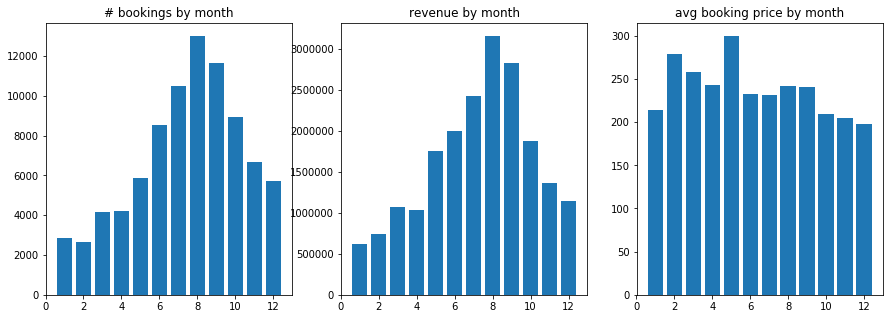

In [0]:
#@title Best months for rental?

plt.figure(figsize=(15, 5))

# # bookings by month
plotdata = pd_reviews[['date']].groupby(pd_reviews["date"].dt.month).count()
plotdata.rename(columns={'date':'# of bookings'}, inplace=True)

ax = plt.subplot(1, 3, 1)
ax.set_title("# bookings by month")
plt.bar(plotdata.index, plotdata['# of bookings'])

# revenue by month
plotdata2 = pd_bookings[['date','estimated_revenue']].groupby(pd_bookings["date"].dt.month).sum()
plotdata2.rename(columns={'estimated_revenue':'revenue'}, inplace=True)

ax = plt.subplot(1, 3, 2)
ax.set_title("revenue by month")
plt.bar(plotdata2.index, plotdata2['revenue'])

# avg booking price by month
plotdata3 = pd.concat([plotdata, plotdata2], axis=1)
plotdata3['avg booking price'] = plotdata3['revenue'] / plotdata3['# of bookings']
plotdata3.head()

ax = plt.subplot(1, 3, 3)
ax.set_title("avg booking price by month")
plt.bar(plotdata3.index, plotdata3['avg booking price'])

_ = plt.plot()

Jul, Aug and Sep are the best period to maximise revenue.
Before May are the best time for maintenance work
Oct to Dec is a good time to take a break and enjoy the holidays.

Dive into the price, what are the range, and where are the expensive listings? To normalise price to compare between listings, we usually look at per person per night. That's what we usually do when we travel.

count    3818.000000
mean       27.137816
std        19.962500
min         0.037500
25%        14.375000
50%        22.500000
75%        34.500000
max       275.000000
Name: price_per_person_per_night, dtype: float64


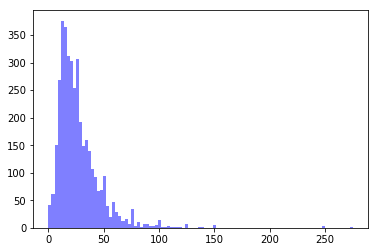

In [0]:
#@title Price distribution of listings, per person, per night
pd_listings['price_per_person_per_night'] = pd_listings['price'] / pd_listings['accommodates'] / pd_listings['minimum_nights']
n, bins, patches = plt.hist(pd_listings['price_per_person_per_night'], 100, facecolor='blue', alpha=0.5)
print(pd_listings['price_per_person_per_night'].describe())

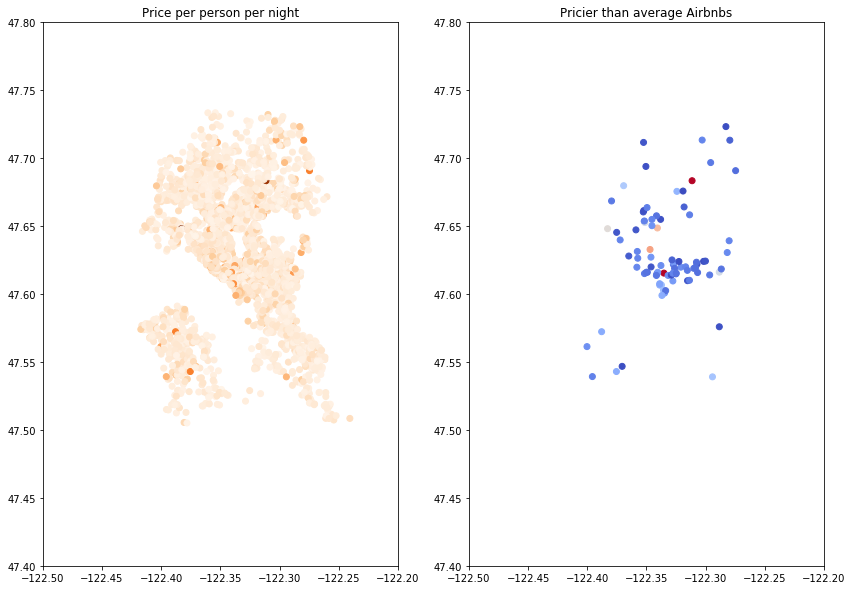

In [0]:
#@title Pricier than average Airbnbs

filter_price_gt = 75

plt.figure(figsize=(14, 10))

ax = plt.subplot(1, 2, 1)
ax.set_title("Price per person per night")

ax.set_autoscaley_on(False)
ax.set_ylim([47.4, 47.8])
ax.set_autoscalex_on(False)
ax.set_xlim([-122.5, -122.2])
plt.scatter(pd_listings["longitude"],
            pd_listings["latitude"],
            cmap="Oranges",
            c=pd_listings["price_per_person_per_night"] / pd_listings["price_per_person_per_night"].max())


ax = plt.subplot(1, 2, 2)
ax.set_title("Pricier than average Airbnbs")

ax.set_autoscaley_on(False)
ax.set_ylim([47.4, 47.8])
ax.set_autoscalex_on(False)
ax.set_xlim([-122.5, -122.2])
plt.scatter(pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["longitude"],
            pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["latitude"],
            cmap="coolwarm",
            c=pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["price"] / pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["price"].max())

_ = plt.plot()

Pricy listings are quite scattered, though we see a cluster of them at the middle.

How about which neighbourhood has the highest revenue?


                              estimated_revenue
neighbourhood_group_cleansed                   
Downtown                            7247.666038
Capitol Hill                        7064.079365
Beacon Hill                         6606.983051
Ballard                             6078.726087
Queen Anne                          6038.752542
Central Area                        4636.371274
Other neighborhoods                 4409.843829
Cascade                             4075.134831
Seward Park                         4063.500000
Rainier Valley                      3827.345912
Delridge                            3641.189873
Magnolia                            3587.819672
West Seattle                        3370.783251
Northgate                           2962.362500
Lake City                           2476.432836
Interbay                            2105.727273
University District                 1558.557377


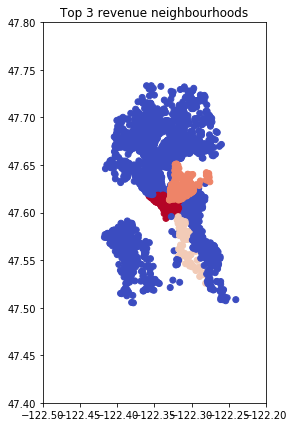

In [0]:
#@title Revenue by neighbourhood

pd_neighbourhood_revenue = pd_listings[['neighbourhood_group_cleansed','estimated_revenue']].groupby(['neighbourhood_group_cleansed']).mean().sort_values('estimated_revenue', ascending=False)
print(pd_neighbourhood_revenue)

pd_listings_plot = pd_listings[['neighbourhood_group_cleansed','longitude','latitude','estimated_revenue']]
pd_listings_plot.loc[:,'color'] = 0

color_value = 1
for neighbourhood in pd_neighbourhood_revenue[0:3].index:
  pd_listings_plot.at[pd_listings_plot['neighbourhood_group_cleansed'] == neighbourhood, 'color'] = color_value
  color_value -= 0.2

# plot
plt.figure(figsize=(4, 7))
ax = plt.subplot(1, 1, 1)
ax.set_title("Top 3 revenue neighbourhoods")

ax.set_autoscaley_on(False)
ax.set_ylim([47.4, 47.8])
ax.set_autoscalex_on(False)
ax.set_xlim([-122.5, -122.2])
plt.scatter(pd_listings_plot['longitude'],
            pd_listings_plot['latitude'],
            cmap="coolwarm",
            c=pd_listings_plot['color']
           )

_ = plt.plot()

Its clear that Downtown, Capitol Hill and Beacon Hill are the highest revenue neighbourhood. From Google Map, those looks like shopping and CBD district

What are the common group size? is it 2? or family of 4? or larger? 
And if guest usually comes in 2s, is it over saturated? (supply and demand)


In [0]:
#@title Guests’ group size, and supply & demand

def get_supply_demand_by(by_column_name, pd_listings, pd_bookings):
  # get supply: number of listing that provide X 
  pd_listing_supply_by_pax = pd_listings[[by_column_name,'listing_id']].groupby([by_column_name]).count().sort_values('listing_id', ascending=False)
  pd_listing_supply_by_pax.rename(columns={'listing_id':'# of listings'}, inplace=True)

  # get demand base on bookings
  pd_listing_demand_by_pax = pd_bookings[[by_column_name,'id']].groupby([by_column_name]).count().sort_values('id', ascending=False)
  pd_listing_demand_by_pax.rename(columns={'id':'# of bookings'}, inplace=True)

  # merge supply and demand
  pd_listing_supply_demand_pax = pd.concat([pd_listing_supply_by_pax, pd_listing_demand_by_pax], axis=1)
  pd_listing_supply_demand_pax['ratio'] = pd_listing_supply_demand_pax['# of bookings'] / pd_listing_supply_demand_pax['# of listings']

  pd_listing_supply_demand_pax = pd_listing_supply_demand_pax.sort_values('ratio', ascending=False)

  return pd_listing_supply_demand_pax

get_supply_demand_by('accommodates', pd_listings, pd_bookings)

,# of listings,# of bookings,ratio
accommodates,,,
14,3,83,27.666667
2,1627,42821,26.318992
3,398,10170,25.552764
10,25,520,20.800000
4,785,16041,20.434395
7,52,956,18.384615
5,184,3221,17.505435
6,332,5580,16.807229
12,15,229,15.266667


A place for 14 ranked first, but the demand is considered low (83 bookings) as compared to places for 2 or 3 person.

Renting a place for 2 or 3 person will give host a pretty good regular rentals.

Do these guests prefer 1 bedroom or 2 separate bedrooms?

In [0]:
#@title Bedrooms configurations for 2 person
get_supply_demand_by('bedrooms', pd_listings[pd_listings['accommodates']<=2], pd_bookings[pd_bookings['accommodates']<=2])

,# of listings,# of bookings,ratio
bedrooms,,,
1.0,1613,40897,25.354619
0.0,261,5376,20.597701
2.0,9,90,10.000000


In [0]:
#@title Bedrooms configurations for 3 person
get_supply_demand_by('bedrooms', pd_listings[pd_listings['accommodates']==3], pd_bookings[pd_bookings['accommodates']==3])

,# of listings,# of bookings,ratio
bedrooms,,,
1.0,311,8214,26.411576
0.0,53,1396,26.339623
2.0,34,560,16.470588


Majority prefers 1 bed room, less than 1% prefers 2 bedrooms (90 out of 40897). But wait, 0 bedrooms, what are kind of apartments are these?

In [0]:
#@title Places with 0 bedrooms
pd_listings[pd_listings['bedrooms']==0][['room_type','listing_id']].groupby(['room_type']).count().sort_values('listing_id', ascending=False)

,listing_id
room_type,
Entire home/apt,378


All these 0 bedrooms apartments are renting their entire home, so we can assume these have 1 room. I hope they provide beds?

In [0]:
#@title Number of beds in 0 bedrooms apartments
pd_bed_count = pd_listings[pd_listings['bedrooms']==0][['beds','listing_id']].groupby(['beds']).count().sort_values('listing_id', ascending=False)
pd_bed_count.rename(columns={'listing_id':'# of listings'}, inplace=True)
pd_bed_count

,# of listings
beds,
1.0,292
2.0,76
3.0,8
4.0,2


At least 1 bed are provided in these 0 bedrooms apartments

In [0]:
#@title Popular bed configurations
pd_bed_count = pd_listings[['beds','listing_id']].groupby(['beds']).count().sort_values('listing_id', ascending=False)
pd_bed_count.rename(columns={'listing_id':'# of listings'}, inplace=True)
pd_bed_count

,# of listings
beds,
1.0,2201
2.0,912
3.0,433
4.0,152
5.0,73
6.0,21
7.0,14
8.0,4
9.0,4


In [0]:
#@title Bedroom configurations with highest demands?
get_supply_demand_by('bedrooms', pd_listings, pd_bookings)

,# of listings,# of bookings,ratio
bedrooms,,,
1.0,2417,61399,25.402979
0.0,378,8403,22.230159
2.0,640,10593,16.551562
6.0,6,82,13.666667
3.0,283,3593,12.696113
5.0,24,205,8.541667
4.0,69,569,8.246377
7.0,1,5,5.000000


1 to 2 bedrooms configuration has most demands, or renting the entire home (zero bedrooms).

Top most correlated columns:
review_scores_communication
review_scores_cleanliness
review_scores_value
review_scores_accuracy
review_scores_checkin
review_scores_location


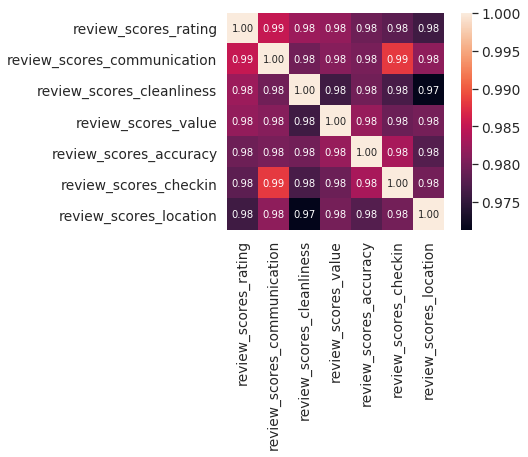

In [0]:
#@title Which factors (ratings) matters the most to visitors of Seattle? 

pd_listings_reviews = pd_listings[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

def plot_topn_correlation_matrix_with_target(df, target_col_name, k=10):
  corrmat = df.corr()
  top_correlated_columns = corrmat.nlargest(k, target_col_name)[target_col_name].index
  cm = np.corrcoef(df[top_correlated_columns].values.T)
  sns.set(font_scale=1.25)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=top_correlated_columns.values, xticklabels=top_correlated_columns.values)
  
  return top_correlated_columns.values

top_correlated_columns = plot_topn_correlation_matrix_with_target(pd_listings_reviews, 'review_scores_rating')

print("Top most correlated columns:")
for i in top_correlated_columns:
  if(i!='review_scores_rating'):
    print(i)


Host with good communication is tends to get high overall rating, host in Seattle needs to be responsive and friendly. Good communication also directly impacts check-in rating.

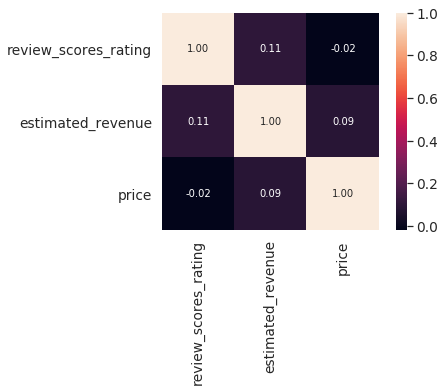

In [0]:
#@title Does good rating affects price and revenue?

_ = plot_topn_correlation_matrix_with_target(pd_listings[['estimated_revenue','price','review_scores_rating']], 'review_scores_rating')

Good rating has little impact to the price set by the host
Good rating also have very small positive correlation with revenue

How about amenities, what other host are providing in their amenities?

In [0]:
#@title These are top 10 most common amenities
rows_amenities = []
rows_listing_id = []

for id, row in pd_listings.loc[:, ['listing_id','amenities']].iterrows():
  rows_listing_id.append(row['listing_id'])
  
  row_amenities = {}
  amenities = row['amenities'].strip('{}')
  for amenity in amenities.split(','):
    row_amenities[amenity.strip('"')] = 1
  rows_amenities.append(row_amenities)

pd_listings_amenities = pd.DataFrame(rows_amenities, index=rows_listing_id)
pd_listings_amenities = pd_listings_amenities.fillna(0)
pd_listings_amenities.drop('', axis=1, inplace=True)
pd_listings_amenities['listing_id'] = pd_listings_amenities.index
pd_listings_amenities = pd.merge(pd_listings_amenities, pd_listings[['listing_id','number_of_reviews']], on='listing_id')

pd_rows_amenities = pd_listings_amenities.sum(axis=0)

pd_amenities_count = pd.DataFrame({'amenities':pd_rows_amenities.index, 'count':pd_rows_amenities.values})
pd_amenities_count = pd_amenities_count.sort_values('count', ascending=False)[:10]

pd_amenities_count.drop(41, axis=0, inplace=True) # drop listing_id
pd_amenities_count.drop(42, axis=0, inplace=True) # drop number_of_reviews
pd_amenities_count

,amenities,count
40,Wireless Internet,3667.0
19,Heating,3627.0
24,Kitchen,3423.0
33,Smoke Detector,3281.0
11,Essentials,3237.0
9,Dryer,2997.0
37,Washer,2992.0
22,Internet,2811.0


Internet, heating and kitchen are listed as necessities in Seattle.

Smoke detector? I just learnt that Washington State Building Code has required smoke detectors in all dwellings since the 1973.

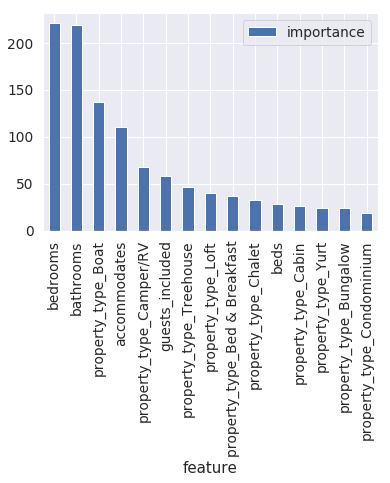

In [0]:
# @title Features with most weight by Linear Regression

# prep data, normalise, one-hot
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

pd_model_data_x = pd_listings[['neighbourhood_group_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms','beds','guests_included']]
pd_model_data_x['accommodates'] = min_max_scaler.fit_transform(pd_model_data_x[['accommodates']])
pd_model_data_x['bathrooms'] = min_max_scaler.fit_transform(pd_model_data_x[['bathrooms']])
pd_model_data_x['bedrooms'] = min_max_scaler.fit_transform(pd_model_data_x[['bedrooms']])
pd_model_data_x['beds'] = min_max_scaler.fit_transform(pd_model_data_x[['beds']])
pd_model_data_x['guests_included'] = min_max_scaler.fit_transform(pd_model_data_x[['guests_included']])

pd_model_data_x = pd.get_dummies(pd_model_data_x, columns=['neighbourhood_group_cleansed','property_type','room_type'])
pd_model_data_y = pd_listings['price']

# train and test - x and y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pd_model_data_x,pd_model_data_y,test_size=0.10, random_state=789)

# linear regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

coefficients = pd.DataFrame({'feature': X_train.columns, 'importance': lm.coef_})
_ = coefficients.sort_values('importance', ascending=False)[:15].plot(x='feature', y='importance', kind='bar')

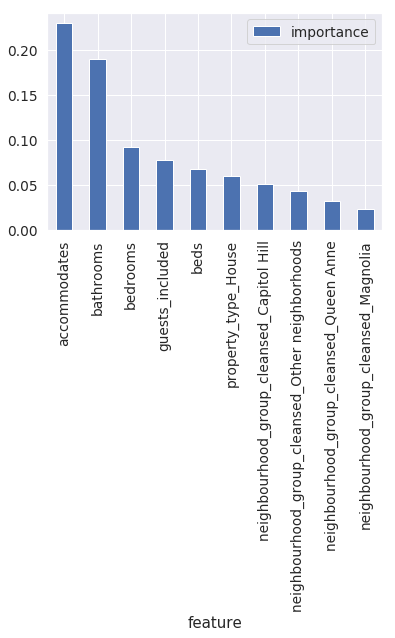

In [0]:
# @title Features with most weight by Decision Tree

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

#Make the decision tree
dtree = tree.DecisionTreeClassifier(
    class_weight="balanced",
    min_weight_fraction_leaf=0.01,)
dtree = dtree.fit(X_train,y_train)

#Look at outputs
importances = dtree.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
_ = tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')


# Conclusion

1)  Calendar

    Jan - April : Maintenance

    May - Sep : rental

    Oct - Dec : Take a break

2) Communications affect overall rating and check in rating.

3) Price and Revenue are not affected by ratings.

4) Make rooms for 2 to 3 guests.

5) Providing wireless internet, heating and kitchen are common.